In [12]:
import os
import sys
import math
import sklearn
import matplotlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm


from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Paths

In [13]:
CSV_PATH = "complete-frame.csv"
CSV_MINER_PATH = "testminereffectiveness.csv"

# Load All the data

In [16]:
def label_rename1 (row):
    return row['path_test'].split('/')[len(row['path_test'].split('/')) - 1].split('.')[0]

def label_rename2 (row):
    return row['path_src'].split('/')[len(row['path_src'].split('/')) - 1].split('.')[0]


def load_frame():
    
    d = {'TestClassName' : 'ClassName',
         'Vocabulary' : 'Vocabulary_prod',
         'Word' : 'Word_prod', 
         'Non Whithe Characters' : 'Non Whithe Characters_prod',
         'No. Methods' : 'No. Methods_prod',
         'Special' : 'Special_prod',
     'No. Method Invoctions' : 'No. Method Invoctions_prod',
    'AST size' : 'AST size_prod', 'Max Depth' : 'Max Depth_prod',
         'Deg2' : 'Deg2_prod',
         'DegPerm' : 'DegPerm_prod',
         'No. Break' : 'No. Break_prod',
         'No. Continue' : 'No. Continue_prod',
     'Avg Depth' : 'Avg Depth_prod', 'Dexterity' : 'Dexterity_prod',
    'No. Expressions' : 'No. Expressions_prod', 'No. Try' : 'No. Try_prod', 'No. Catch' : 'No. Catch_prod',
     'No. Loop' : 'No. Loop_prod', 'No. Conditions' : 'No. Conditions_prod', 'No. Else' : 'No. Else_prod'}
    
    
    frame1 = pd.read_csv(CSV_PATH, sep=",")
    frame1 = frame1.sample(frac=1).reset_index(drop=True)
    frame1['TestClassName'] = frame1.apply(lambda row: label_rename1(row), axis=1)
    frame1['ClassName'] = frame1.apply(lambda row: label_rename2(row), axis=1)
        
    
    frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
    
    frame3 = pd.read_csv(CSV_MINER_PATH, sep=',')
    frame3 = frame3.rename(columns = d)
    frame3 = frame3.drop(['Bad API', 'Junit', 'Hamcrest', 'Mockito', 'Nº','Project'], axis=1)
    
    
    frame = pd.merge(frame1, frame2, on='TestClassName')
    
    frame = pd.merge(frame, frame3, on='ClassName')
    

    frame = frame.drop(['project', 'module', 'path_test','test_name','path_src',
                        'commit', 'class_name'], axis=1)
    frame = frame.sample(frac=1).reset_index(drop=True)
    frame = frame.dropna()

    return frame

def load_frame_with_projects():
    frame1 = pd.read_csv(CSV_PATH, sep=",")
    frame1 = frame1.sample(frac=1).reset_index(drop=True)
    frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
    frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
    frame = pd.merge(frame1, frame2, on='TestClassName')
    frame = frame.drop(['module', 'path_test','test_name','path_src',
                        'class_name','TestClassName','commit','Nº','Project'], axis=1)
    frame = frame.sample(frac=1).reset_index(drop=True)
    frame = frame.dropna()

    return frame


def load_static_frame():
    frame1 = pd.read_csv(CSV_PATH, sep=",")
    frame1 = frame1.sample(frac=1).reset_index(drop=True)
    frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
    frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
    frame = pd.merge(frame1, frame2, on='TestClassName')
    frame = frame.drop(['project', 'module', 'path_test','test_name','path_src',
                        'class_name','TestClassName','commit','Nº','Project'], axis=1)
    frame = frame.sample(frac=1).reset_index(drop=True)
    frame = frame.dropna()

    return frame


def load_quartile(frame):
    low, high = frame.mutation.quantile([0.25,0.75])
    frame_low = frame.query('mutation<{low}'.format(low=low))
    frame_high = frame.query('mutation>{high}'.format(high=high))
    frame_low['mutation'] = 0
    frame_high['mutation'] = 1
    frame = pd.concat([frame_low, frame_high], ignore_index=True)
    frame = frame.sample(frac=1).reset_index(drop=True)
    return frame;

def load_meaningful_subset(frame):
    columns = [frame.no_mutations,
                         frame.line_coverage,
                         frame.csm_FE,
                         frame.CONNECTIVITY_prod,
                         frame.CONNECTIVITY_test,
                         frame.isEagerTest,
                         frame.LOC_prod, frame.LOC_test, frame.WMC_prod,
                         frame.LCOM1_prod, frame.LCOM2_prod,
                         frame.LCOM4_prod, frame.McCABE_prod,
                         frame.RFC_prod, frame.MPC_prod,
                         frame.RFC_test, frame.MPC_test,
                         frame.LCOM1_test, frame.LCOM2_test,
                         frame.LCOM4_test, frame.LCC_test,
                         frame.LCC_test, frame.WMC_test,
                         frame.McCABE_test, frame.NOP_prod]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)


def load_meaningful_subset_static(frame):
    columns = [frame.no_mutations,
                         frame.csm_FE,
                         frame.CONNECTIVITY_prod,
                         frame.CONNECTIVITY_test,
                         frame.isEagerTest,
                         frame.LOC_prod, frame.LOC_test, frame.WMC_prod,
                         frame.LCOM1_prod, frame.LCOM2_prod,
                         frame.LCOM4_prod, frame.McCABE_prod,
                         frame.RFC_prod, frame.MPC_prod,
                         frame.RFC_test, frame.MPC_test,
                         frame.LCOM1_test, frame.LCOM2_test,
                         frame.LCOM4_test, frame.LCC_test,
                         frame.LCC_test, frame.WMC_test,
                         frame.McCABE_test, frame.NOP_prod]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

def load_meaningful_subset_2(frame):
    #columns = [frame.line_coverage, frame.isAssertionRoulette, frame.isMysteryGuest,
    #   frame.isResourceOptimism, frame.isForTestersOnly, frame.COH_prod, frame.BUSWEIMER_prod,
    #   frame.BUSWEIMER_test, frame.csm_LM, frame.prod_readability]
    
    [frame.line_coverage,
    frame.COH_prod, frame.BUSWEIMER_prod, frame.csm_MC,
       frame.prod_readability, frame.prod_readability]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)



def load_all_data(frame):
    columns = ['isAssertionRoulette',
       'isEagerTest', 'isLazyTest', 'isMysteryGuest',
       'isSensitiveEquality', 'isResourceOptimism', 'isForTestersOnly',
       'isIndirectTesting', 'LOC_prod', 'HALSTEAD_prod', 'RFC_prod',
       'CBO_prod', 'MPC_prod', 'IFC_prod', 'DAC_prod', 'DAC2_prod',
       'LCOM1_prod', 'LCOM2_prod', 'LCOM3_prod', 'LCOM4_prod',
       'CONNECTIVITY_prod', 'LCOM5_prod', 'COH_prod', 'TCC_prod',
       'LCC_prod', 'ICH_prod', 'WMC_prod', 'NOA_prod', 'NOPA_prod',
       'NOP_prod', 'McCABE_prod', 'BUSWEIMER_prod', 'LOC_test',
       'HALSTEAD_test', 'RFC_test', 'CBO_test', 'MPC_test', 'IFC_test',
       'DAC_test', 'DAC2_test', 'LCOM1_test', 'LCOM2_test', 'LCOM3_test',
       'LCOM4_test', 'CONNECTIVITY_test', 'LCOM5_test', 'COH_test',
       'TCC_test', 'LCC_test', 'ICH_test', 'WMC_test', 'NOA_test',
       'NOPA_test', 'NOP_test', 'McCABE_test', 'BUSWEIMER_test',
       'csm_CDSBP', 'csm_CC', 'csm_FD', 'csm_Blob', 'csm_SC', 'csm_MC',
       'csm_LM', 'csm_FE', 'prod_readability', 'test_readability', 'No. Methods', 'Vocabulary', 'Word',
               'Special', 'Non Whithe Characters', 'No. Method Invoctions', 'AST size', 'Max Depth',
               'Avg Depth', 'Deg2', 'DegPerm', 'Dexterity', 'No. Expressions', 'No. Try', 'No. Catch',
               'No. Loop', 'No. Break', 'No. Continue', 'No. Conditions', 'No. Else', 'Bad API',
               'Junit', 'Hamcrest', 'Mockito', 'No. Methods_prod', 'Vocabulary_prod', 'Word_prod',
               'Special_prod', 'Non Whithe Characters_prod', 'No. Method Invoctions_prod', 'AST size_prod',
               'Max Depth_prod', 'Avg Depth_prod', 'Deg2_prod', 'DegPerm_prod', 'Dexterity_prod',
               'No. Expressions_prod', 'No. Try_prod', 'No. Catch_prod', 'No. Loop_prod', 'No. Break_prod',
               'No. Continue_prod', 'No. Conditions_prod', 'No. Else_prod']

    data_x = frame[columns].round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)
    

def load_all_data_with_mine(frame):
    columns = [frame.no_mutations, frame.line_coverage, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability,frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)


def load_all_data_static(frame):
    columns = [frame.no_mutations, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)
    

def load_all_data_with_mine_static(frame):
    columns = [frame.no_mutations, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability,frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

def load_mine(frame):
    columns = [frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters, frame.mutation]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

# Grid - Static with all their data + my data

In [4]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', activation='linear', init_mode='uniform', dropout_rate=0.1):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(dropout_rate, input_shape=(82,)))
    model.add(keras.layers.Dense(40, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(20, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(2, kernel_initializer=init_mode, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
frame = load_frame()
frame = load_quartile(frame)

data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

data_x = data_x.values
data_y = data_y.values

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)


early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=10, verbose=0, mode='max', restore_best_weights=True)

model = KerasClassifier(build_fn=create_model, verbose=0, epochs=2000)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
dropout_rate = [0.2, 0.25, 0.3]
param_grid = dict(batch_size=batch_size, optimizer=optimizer, activation=activation, dropout_rate=dropout_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=kfold, verbose=2)
grid_result = grid.fit(data_x, data_y, callbacks=[early_stopping_monitor])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1008 candidates, totalling 10080 fits
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 


KeyboardInterrupt: 

# Grid - predict the exact mutation score value (Dynamic)

In [18]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', activation='linear', init_mode='uniform', dropout_rate=0.1):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(dropout_rate, input_shape=(82,)))
    model.add(keras.layers.Dense(40, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(20, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(2, kernel_initializer=init_mode, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
frame = load_frame()
frame = load_quartile(frame)

data_x, data_y, number_of_features = load_all_data(frame)

data_x = data_x.values
data_y = data_y.values

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)


early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=10, verbose=0, mode='max', restore_best_weights=True)

model = KerasClassifier(build_fn=create_model, verbose=0, epochs=2000)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
dropout_rate = [0.2, 0.25, 0.3]
param_grid = dict(batch_size=batch_size, optimizer=optimizer, activation=activation, dropout_rate=dropout_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)



grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=kfold, verbose=2)
grid_result = grid.fit(data_x, data_y, callbacks=[early_stopping_monitor])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters wi

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_24_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_25_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_47_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_48_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_70_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_71_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_93_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_94_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_118_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_119_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropo

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_141_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_142_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropo

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_166_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_167_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropo

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_191_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropout_192_input to have shape (82,) but got array with shape (110,)

  FitFailedWarning)
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dropo

KeyboardInterrupt: 

In [ ]:
load_all_data_with_mine(load_frame())

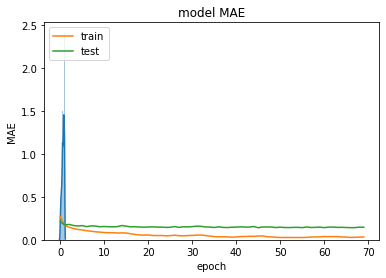

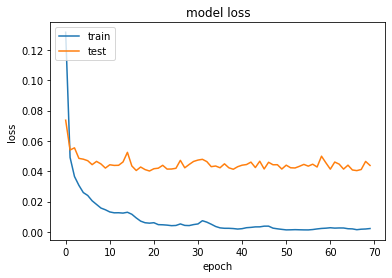

ValueError: too many values to unpack (expected 2)

In [21]:
def silent_evaluation(model, x_test, y_test):
    f = open('/dev/null', 'w')
    regular_stdout = sys.stdout
    sys.stdout = f
    test_loss, test_acc = model.evaluate(x_test, y_test)
    sys.stdout = regular_stdout
    print('Model Accuracy: {}'.format(test_acc))
    
def split_data(train_x, train_y, training=0.70, validation=0.5):
    train_size = training

    train_cnt = math.floor(train_x.shape[0] * train_size)
    x_train = train_x[0:train_cnt]
    y_train = train_y[0:train_cnt]
    x_test = train_x[train_cnt:]
    y_test = train_y[train_cnt:]

    division = validation

    train_cnt = math.floor(x_test.shape[0] * division)
    x_validate = x_test[0:train_cnt]
    y_validate = y_test[0:train_cnt]
    x_test = x_test[train_cnt:]
    y_test = y_test[train_cnt:]

    return x_train, y_train, x_test, y_test, x_validate, y_validate    

frame = load_frame()
data_x, data_y, number_of_features = load_all_data(frame) #load_meaningful_subset(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2).values


scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)

sns.distplot(data_y);


x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)

print(x_train.shape)
model = keras.Sequential()
model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae','mse'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)


history = model.fit(x_train, y_train, epochs=1000, verbose=1, validation_data=(x_validate, y_validate),
                    callbacks=[early_stopping_monitor])


# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

silent_evaluation(model, x_test, y_test)


print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.concatenate(y_pred).tolist()
y_pred


In [ ]:
y_testi = np.concatenate(y_test).tolist()
y_testi

In [ ]:
#err = y_test - y_pred
err = [abs(e1 - e2) for e1, e2 in zip(y_test,y_pred)]
err = np.concatenate(err).tolist()
err

In [ ]:
list(zip(y_testi,err))

In [ ]:
plt.scatter(*zip(*list(zip(y_testi,err))))
plt.ylabel('Absolute Prediction Error')
plt.xlabel('Real Mutation Score')
#plt.show()
#plt.show()
plt.savefig("foo.pdf", bbox_inches='tight')
plt.close()

In [ ]:
import statistics

err = [abs(e1 - e2) for e1, e2 in zip(y_test,y_pred)]
statistics.mean(err)

In [ ]:
keras.utils.plot_model(model, to_file='model.pdf')

In [ ]:
import scipy.stats as stats


#frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
#           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
#           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters]
    
frame = load_frame()


x1 = frame['mutation']#[12, 2, 1, 12, 2]
x2 = frame['TryCatch'] #[1, 4, 7, 1, 0]

#x1 = [12, 1, 2, 12, 2]
#x2 = [1, 7, 4, 1, 0]

tau, p_value = stats.kendalltau(x1, x2)

In [ ]:
tau

In [ ]:
p_value

In [ ]:
frame = load_frame_with_projects()
#pd.unique(frame['project'])

In [ ]:
frame

In [ ]:
frame = load_frame_with_projects()
projects = ['commons-lang', 'javapoet', 'commons-io', 'jfreechart',
       'commons-math', 'opengrok', 'checkstyle', 'closure-compiler',
       'RxJava', 'fastjson', 'cat', 'joda-beans', 'commons-collections',
       'junit4', 'gson', 'jsoup', 'guice']
for project in projects:
    small_frame = frame[frame['project']==project]
    x1 = small_frame['mutation']
    x2= small_frame['Assrtions']
    tau, p_value = stats.kendalltau(x1, x2)
    print('project {}, tau: {}, p: {}'.format(project,tau,p_value))
    
#['commons-lang', 'javapoet', 'commons-io', 'jfreechart',
#       'commons-math', 'opengrok', 'checkstyle', 'closure-compiler',
#       'RxJava', 'fastjson', 'cat', 'joda-beans', 'commons-collections',
#       'junit4', 'gson', 'jsoup', 'guice']



In [ ]:
frame = load_frame_with_projects()
me = ['Assrtions', 'Conditions', 'TryCatch', 'Loop', 'Hamcrest' , 'Mockito',
           'BadApi', 'LOC' ,'Expressions', 'Depth', 'Vocabulary', 'Understandability', 'BodySize'
     , 'Dexterity', 'NonWhiteCharacters']

labels = [1,2]
bins = [0,frame.mutation.median(),1]
frame['mutation_bins'] = pd.cut(frame.mutation, bins=bins, labels = labels, include_lowest=True)
    
for m in me:
    x1 = frame['mutation'].round(1) #['mutation_bins']
    x2 = frame[m] #/frame['LOC_test']
    tau, p_value = stats.kendalltau(x1, x2)
    print('metric {}, tau: {:.3f}, p: {:.3f}'.format(m,tau,p_value))

In [ ]:
import scipy.stats as s

s.ranksums(frame.Loop['mutation_bins'==1],frame.Loop['mutation_bins'==2])

In [ ]:

frame['mutation_bins']

In [ ]:
frame['LOC_test']

In [ ]:
frame = load_frame_with_projects()
frame['Assrtions']/frame['LOC']

In [ ]:
x1 = is_checkstyle['mutation']#[12, 2, 1, 12, 2]
x2 = is_checkstyle['TryCatch'] #[1, 4, 7, 1, 0]

#x1 = [12, 1, 2, 12, 2]
#x2 = [1, 7, 4, 1, 0]

tau, p_value = stats.kendalltau(x1, x2)

In [ ]:
tau

In [ ]:
p_value

In [ ]:
frame1 = pd.read_csv('good_tests.csv', sep=",")
frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
frame = pd.merge(frame1, frame2, on='TestClassName')
#frame
frame.to_csv ('good_tests_extended.csv', index = False, header=True)

In [ ]:
frame1 = pd.read_csv('bad_tests.csv', sep=",")
frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
frame = pd.merge(frame1, frame2, on='TestClassName')
frame.to_csv ('bad_tests_extended.csv', index = False, header=True)